In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
cch2 = pd.read_csv("continental_US_CCH2/full_dataset.csv")
len(cch2)

/home/jackson/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,26,28,29,42,44,50,56,65,67,73,75) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


1513533

In [4]:
species_of_interest = [
    "Cuscuta campestris",
    "Trifolium pratense",
    "Ricinus communis",
    "Brassica rapa",
    "Raphanus sativus",
    "Nicotiana attenuata",
    "Helianthus annuus",
    "Guttata sensu lato"
]

In [5]:
subsets = {}
species_counts = [[],[]]
for sp in species_of_interest:
    subset = cch2.loc[(cch2["scientificName"].str.lower()==sp.lower())]
    n_subset = len(subset)
    n_filtered_subset = len(subset.loc[(~cch2["month"].isna()) &
                        (~cch2["flowering"].isna()) &
                        (~cch2["fruiting"].isna())])
    if subset is not None and n_subset > 50:
        print("{}: {}".format(sp, n_subset, n_filtered_subset))
        subsets[sp] = subset
    elif n_subset < 50 and n_subset > 1:
        print("{}: {} -- Too few!".format(sp, n_subset))
    else:
        print("{} not found".format(sp))

Cuscuta campestris: 178
Trifolium pratense: 214
Ricinus communis: 352
Brassica rapa: 471
Raphanus sativus: 749
Nicotiana attenuata: 479
Helianthus annuus: 551
Guttata sensu lato: 2266


In [6]:
from scipy import stats
from sklearn.linear_model import LinearRegression

def run_linear_model(X, y, verbose=False, skip_insignificant=False, alpha=0.05, plot_flag=True):
    if verbose:
        print("##############################")
        print("Linear model:")
        print("Predicting {} from {}".format(y.name, list(X.columns)))
    
    lm = LinearRegression()
    model = lm.fit(X,y)
    
    predictions = lm.predict(X)
    residuals = y - predictions
    R_squared = lm.score(X,y)
    coefficients = lm.coef_
    intercept = lm.intercept_
    
    # Get p-values for each of the parameters
    # Code found at https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
    params = np.append(intercept,coefficients)
    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]
    
    # Plot the model with predictions if only one predictor
    if plot_flag:
        if len(X.columns) == 1:
            if skip_insignificant and p_values[1] > alpha:
                if verbose:
                    print("Skipped -- Result is insignificant (alpha = {})".format(alpha))
                    print("##############################\n")
            else:
                col = X.columns[0]
                plt.scatter(X[col], y, alpha=0.1, color="b")
                plt.plot(X[col], predictions, color="r", label="y = {:.3E}*x + {:.3E}".format(coefficients[0], intercept))
                plt.xlabel(col)
                plt.ylabel(y.name)
                plt.legend()
                plt.title("Linear Model (R^2 = {:.3f}, p = {:.2E})".format(R_squared, p_values[1]))
                plt.show()
                plt.clf()
        else:
            print("\nR^2 = {:.3f}\n".format(R_squared))
            print("{:15}  {:8} (p-value)".format("Predictor", "Coeff"))
            print("---------------------------------------")
            print("{:15}: {:8.4f} (p = {:.2E})".format("Intercept", intercept, p_values[0]))
            for idx, col in enumerate(X.columns):
                print("{:15}: {:8.4f} (p = {:.2E})".format(col, coefficients[idx], p_values[idx+1]))
    
    if verbose:
        # Plot the histogram of residuals
        plt.hist(residuals, bins=30, density=True)
        plt.xlabel("Residual")
        plt.ylabel("Density")
        plt.title("Residual Density Histogram")
        plt.show()

        print("##############################\n")
    
    return R_squared, p_values, params[1]

##############################
Linear model:
Predicting startDayOfYear from ['year']


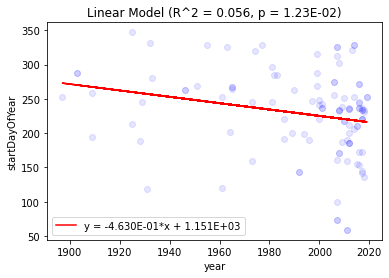

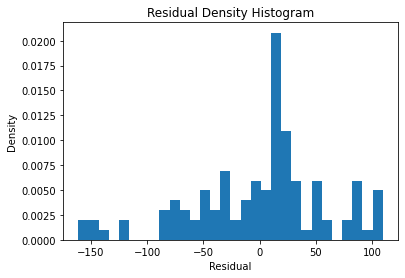

##############################

##############################
Linear model:
Predicting startDayOfYear from ['year']


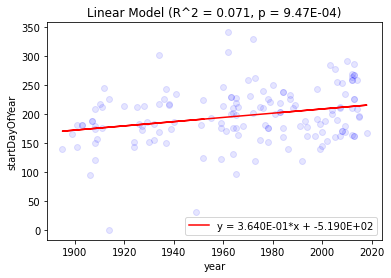

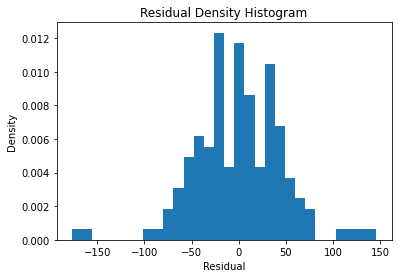

##############################

##############################
Linear model:
Predicting startDayOfYear from ['year']


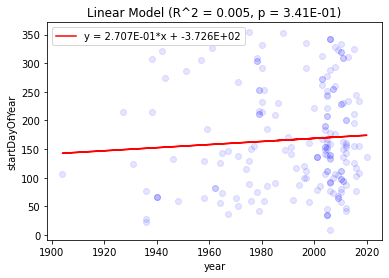

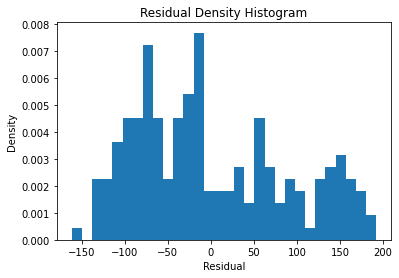

##############################

##############################
Linear model:
Predicting startDayOfYear from ['year']


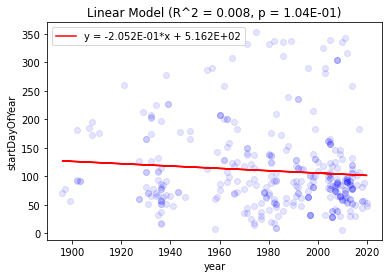

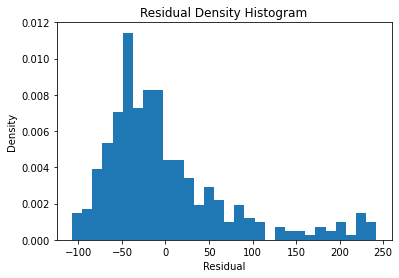

##############################

##############################
Linear model:
Predicting startDayOfYear from ['year']


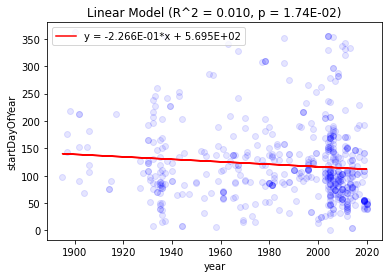

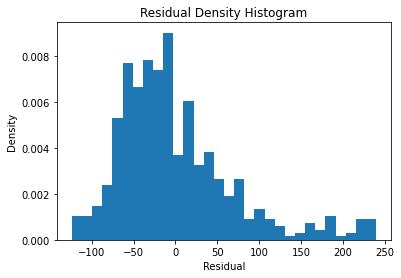

##############################

##############################
Linear model:
Predicting startDayOfYear from ['year']


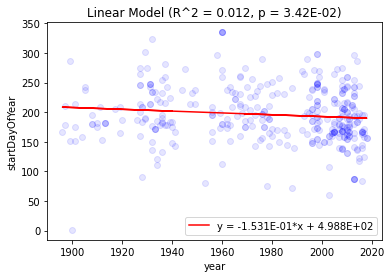

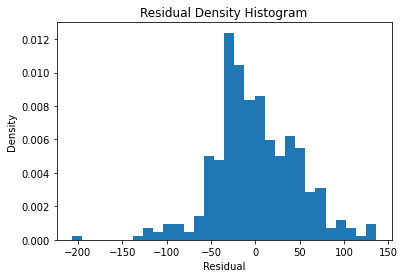

##############################

##############################
Linear model:
Predicting startDayOfYear from ['year']


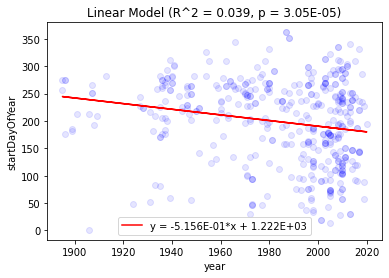

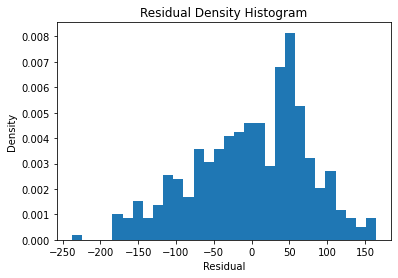

##############################

##############################
Linear model:
Predicting startDayOfYear from ['year']


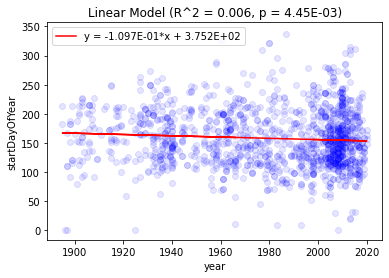

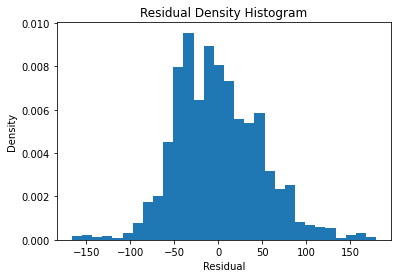

##############################

##############################
Linear model:
Predicting startDayOfYear from ['year']


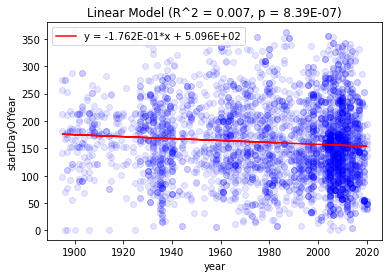

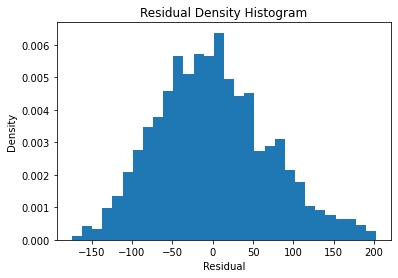

##############################



(0.006702401962370486,
 [7.203126983768016e-13, 8.386313867791984e-07],
 -0.17616651132554098)

In [24]:
from sklearn.linear_model import LinearRegression

yrs = np.array(list(range(1895, 2021))).reshape(-1, 1)

for sp, subset in subsets.items():
    subset = subset.loc[(~subset["year"].isna()) &
                        (~subset["flowering"].isna()) &
                        (~subset["startDayOfYear"].isna())]
    subset = subset.loc[subset["flowering"]==1, ["startDayOfYear", "year"]]
    #subset = subset.loc[subset["year"] >= 1920]
    run_linear_model(subset[["year"]], subset["startDayOfYear"], verbose=True)
subset = cch2.loc[(cch2["scientificName"].str.lower().isin([s.lower() for s in species_of_interest])) &
                  (~cch2["year"].isna()) &
                  (~cch2["flowering"].isna()) &
                  (~cch2["startDayOfYear"].isna())]
subset = subset.loc[subset["flowering"]==1, ["startDayOfYear", "year"]]
run_linear_model(subset[["year"]], subset["startDayOfYear"], verbose=True)

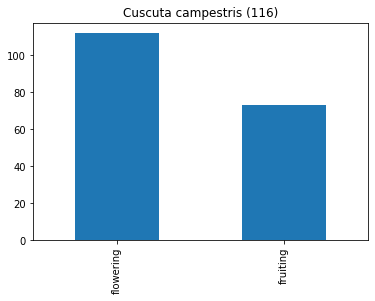

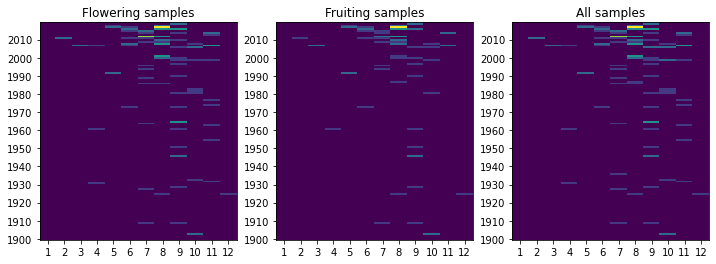

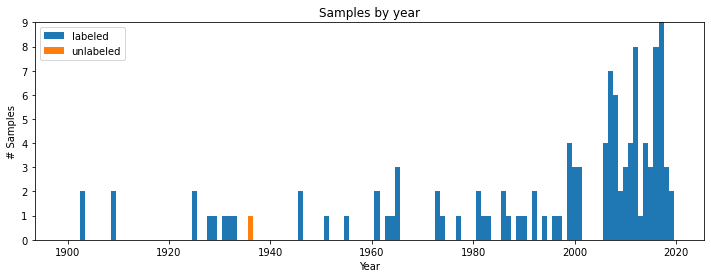

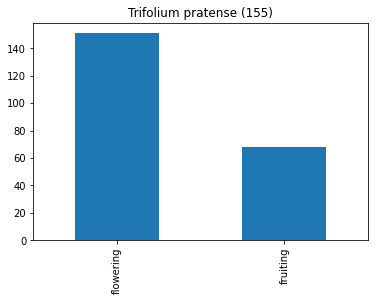

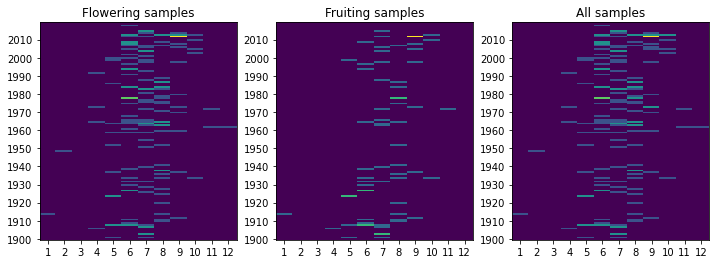

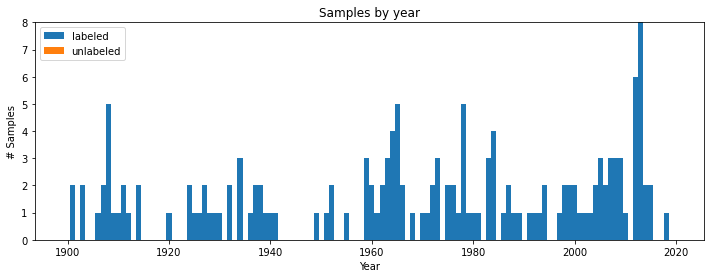

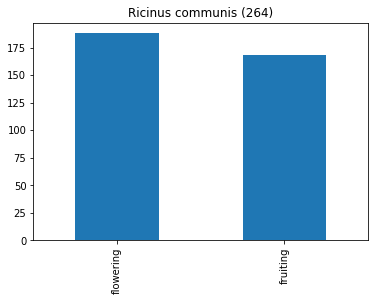

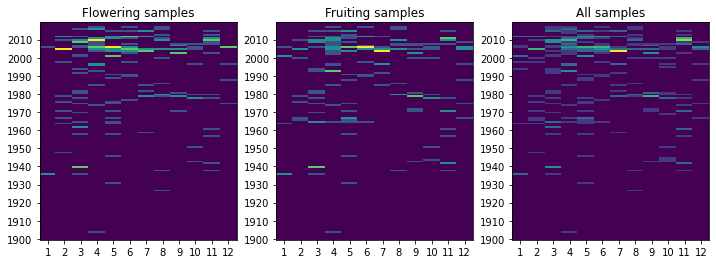

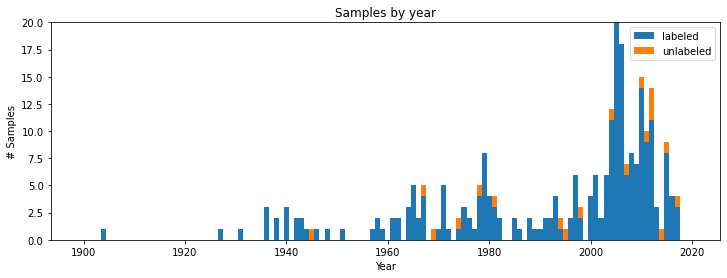

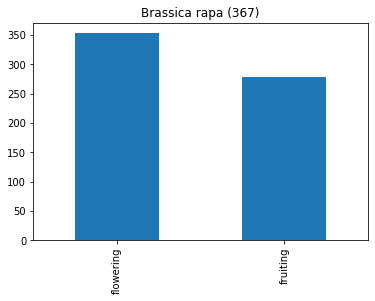

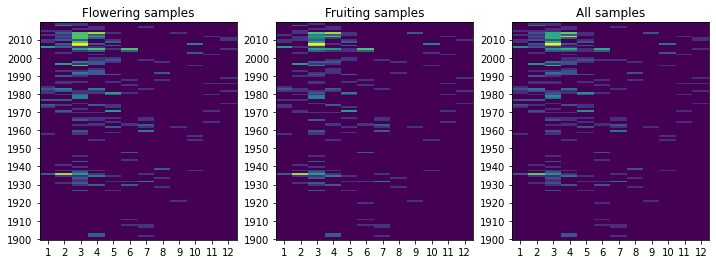

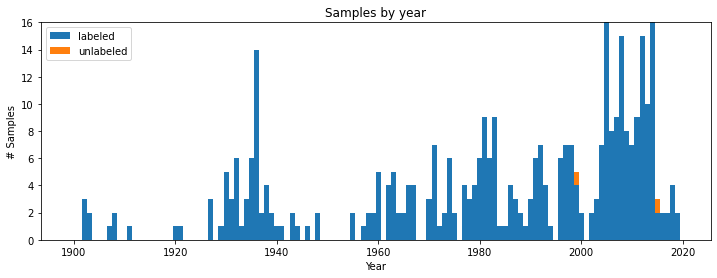

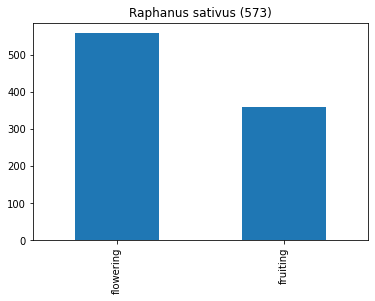

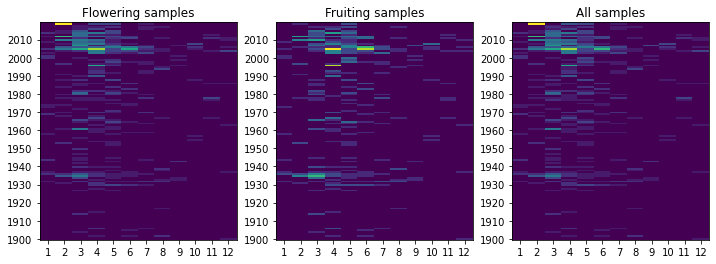

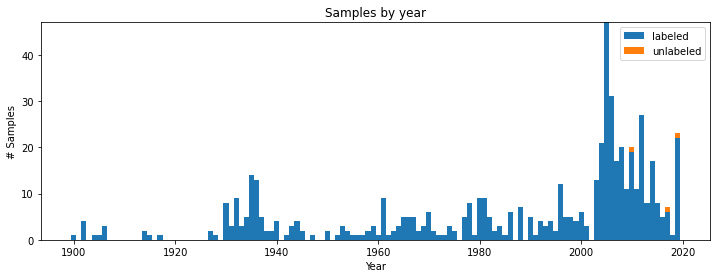

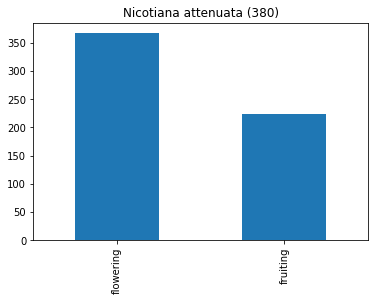

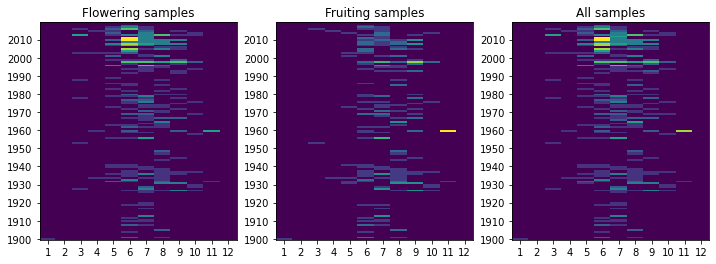

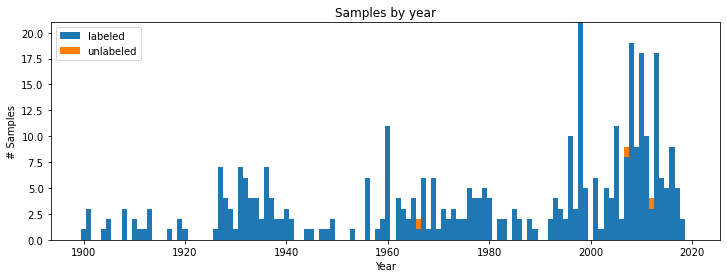

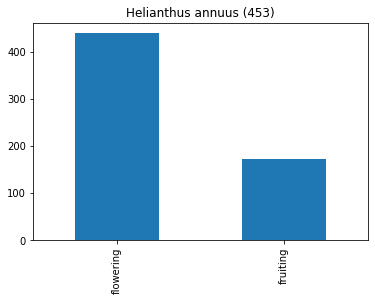

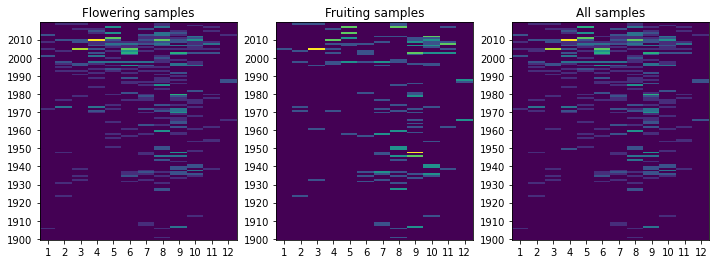

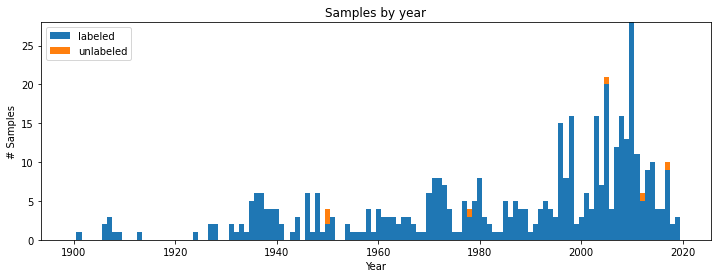

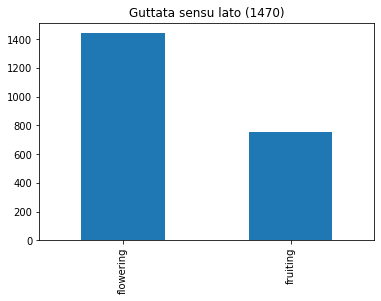

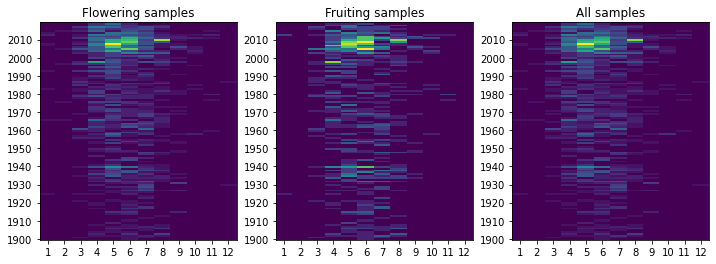

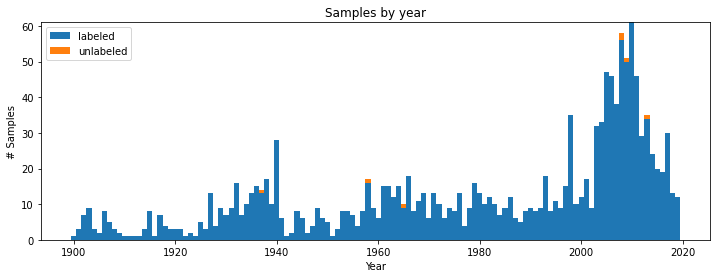

In [8]:
for sp, subset in subsets.items():
    subset = subset.loc[(~cch2["month"].isna()) &
                        (~cch2["flowering"].isna()) &
                        (~cch2["fruiting"].isna())]
    subset[["flowering", "fruiting"]].sum(axis=0).plot.bar(title="{} ({})".format(sp, len(subset)))
    plt.show()

    _, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

    by_time = pd.crosstab(subset.loc[subset["flowering"]==1, "year"].astype(int), subset.loc[subset["flowering"]==1, "month"].astype(int))
    by_time = by_time.reindex(index=range(1900, 2020), columns=range(1, 13)).fillna(0)
    subsampled_index = range(1900, 2020, 10)
    ax1.pcolor(by_time)
    ax1.set_title("Flowering samples")
    ax1.set_yticks(np.arange(0.5, len(subsampled_index)*10, 10))
    ax1.set_yticklabels(subsampled_index)
    ax1.set_xticks(np.arange(0.5, len(by_time.columns), 1))
    ax1.set_xticklabels(by_time.columns)

    by_time = pd.crosstab(subset.loc[subset["fruiting"]==1, "year"].astype(int), subset.loc[subset["fruiting"]==1, "month"].astype(int))
    by_time = by_time.reindex(index=range(1900, 2020), columns=range(1, 13)).fillna(0)
    ax2.pcolor(by_time)
    ax2.set_title("Fruiting samples")
    ax2.set_yticks(np.arange(0.5, len(subsampled_index)*10, 10))
    ax2.set_yticklabels(subsampled_index)
    ax2.set_xticks(np.arange(0.5, len(by_time.columns), 1))
    ax2.set_xticklabels(by_time.columns)

    by_time = pd.crosstab(subset["year"].astype(int), subset["month"].astype(int))
    by_time = by_time.reindex(index=range(1900, 2020), columns=range(1, 13)).fillna(0)
    ax3.pcolor(by_time)
    ax3.set_title("All samples")
    ax3.set_yticks(np.arange(0.5, len(subsampled_index)*10, 10))
    ax3.set_yticklabels(subsampled_index)
    ax3.set_xticks(np.arange(0.5, len(by_time.columns), 1))
    ax3.set_xticklabels(by_time.columns)
    plt.show()

    plt.figure(figsize=(12,4))
    years = subset.loc[((subset["flowering"]==1)|(subset["fruiting"]==1)), "year"].astype(int).value_counts()
    years_labeled = years.reindex(range(1900, 2020)).fillna(0)
    plt.bar(years_labeled.index,
            years_labeled.values,
            1.0,
            label="labeled")
    years = subset["year"].astype(int).value_counts()
    years_unlabeled = years.reindex(range(1900, 2020)).fillna(0) - years_labeled
    plt.bar(years_unlabeled.index,
            years_unlabeled.values,
            1.0,
            bottom=years_labeled.values,
            label="unlabeled")
    plt.legend()
    plt.title("Samples by year")
    plt.xlabel("Year")
    plt.ylabel("# Samples")
    plt.show()

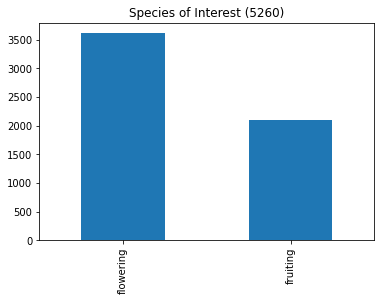

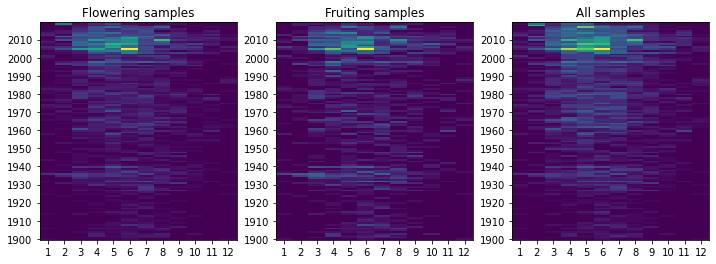

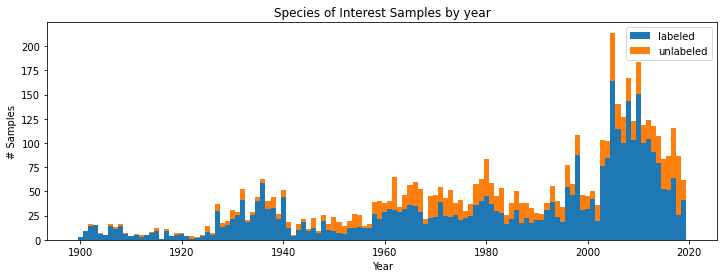

In [9]:
subset = cch2.loc[cch2["scientificName"].str.lower().isin([sp.lower() for sp in species_of_interest])]
subset = subset.loc[(~cch2["month"].isna())]
subset[["flowering", "fruiting"]].sum(axis=0).plot.bar(title="{} ({})".format("Species of Interest", len(subset)))
plt.show()

_, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

by_time = pd.crosstab(subset.loc[subset["flowering"]==1, "year"].astype(int), subset.loc[subset["flowering"]==1, "month"].astype(int))
by_time = by_time.reindex(index=range(1900, 2020), columns=range(1, 13)).fillna(0)
subsampled_index = range(1900, 2020, 10)
ax1.pcolor(by_time)
ax1.set_title("Flowering samples")
ax1.set_yticks(np.arange(0.5, len(subsampled_index)*10, 10))
ax1.set_yticklabels(subsampled_index)
ax1.set_xticks(np.arange(0.5, len(by_time.columns), 1))
ax1.set_xticklabels(by_time.columns)

by_time = pd.crosstab(subset.loc[subset["fruiting"]==1, "year"].astype(int), subset.loc[subset["fruiting"]==1, "month"].astype(int))
by_time = by_time.reindex(index=range(1900, 2020), columns=range(1, 13)).fillna(0)
ax2.pcolor(by_time)
ax2.set_title("Fruiting samples")
ax2.set_yticks(np.arange(0.5, len(subsampled_index)*10, 10))
ax2.set_yticklabels(subsampled_index)
ax2.set_xticks(np.arange(0.5, len(by_time.columns), 1))
ax2.set_xticklabels(by_time.columns)

by_time = pd.crosstab(subset["year"].astype(int), subset["month"].astype(int))
by_time = by_time.reindex(index=range(1900, 2020), columns=range(1, 13)).fillna(0)
ax3.pcolor(by_time)
ax3.set_title("All samples")
ax3.set_yticks(np.arange(0.5, len(subsampled_index)*10, 10))
ax3.set_yticklabels(subsampled_index)
ax3.set_xticks(np.arange(0.5, len(by_time.columns), 1))
ax3.set_xticklabels(by_time.columns)
plt.show()

plt.figure(figsize=(12,4))
years = subset.loc[((subset["flowering"]==1)|(subset["fruiting"]==1)), "year"].astype(int).value_counts()
years_labeled = years.reindex(range(1900, 2020)).fillna(0)
plt.bar(years_labeled.index,
        years_labeled.values,
        1.0,
        label="labeled")
years = subset["year"].astype(int).value_counts()
years_unlabeled = years.reindex(range(1900, 2020)).fillna(0) - years_labeled
plt.bar(years_unlabeled.index,
        years_unlabeled.values,
        1.0,
        bottom=years_labeled.values,
        label="unlabeled")
plt.legend()
plt.title("Species of Interest Samples by year")
plt.xlabel("Year")
plt.ylabel("# Samples")
plt.show()

Cuscuta campestris 116


100%|██████████| 123/123 [00:00<00:00, 786.06it/s]


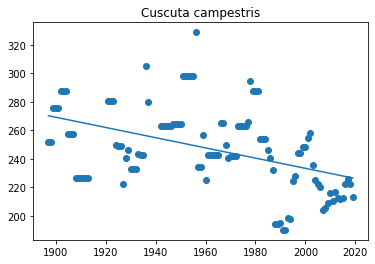

R squared: 0.20045231075340908
MFT: 229.16379310344828
Change in MFT 1895-2020: [-44.86907078]
Change in MFT 1920-2020: [-35.89525663]
Trifolium pratense 155


100%|██████████| 124/124 [00:00<00:00, 774.05it/s]


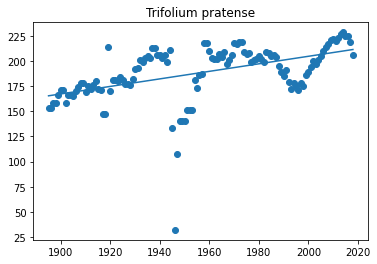

R squared: 0.2436034656020114
MFT: 198.8967741935484
Change in MFT 1895-2020: [46.77097993]
Change in MFT 1920-2020: [37.41678395]
Ricinus communis 264


100%|██████████| 117/117 [00:00<00:00, 804.12it/s]


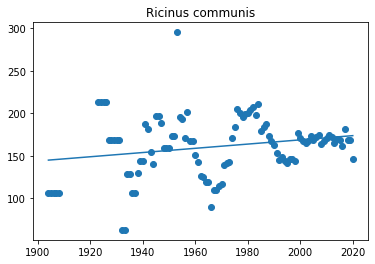

R squared: 0.048110978632249224
MFT: 170.43560606060606
Change in MFT 1895-2020: [31.02378112]
Change in MFT 1920-2020: [24.8190249]
Brassica rapa 367


100%|██████████| 125/125 [00:00<00:00, 810.10it/s]


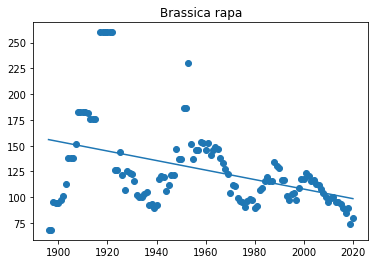

R squared: 0.16500612414374694
MFT: 110.01907356948229
Change in MFT 1895-2020: [-57.71614213]
Change in MFT 1920-2020: [-46.1729137]
Raphanus sativus 573


100%|██████████| 126/126 [00:00<00:00, 801.89it/s]


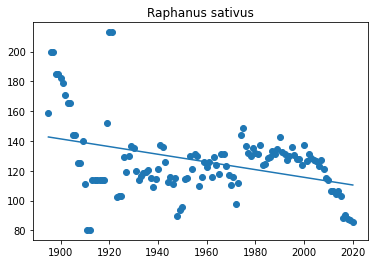

R squared: 0.15022468862361282
MFT: 120.27923211169285
Change in MFT 1895-2020: [-32.22611787]
Change in MFT 1920-2020: [-25.78089429]
Nicotiana attenuata 380


100%|██████████| 123/123 [00:00<00:00, 786.32it/s]


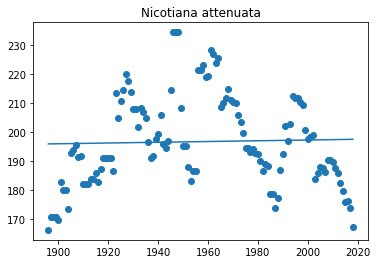

R squared: 0.0008810219528436747
MFT: 197.23026315789474
Change in MFT 1895-2020: [1.62158495]
Change in MFT 1920-2020: [1.29726796]
Helianthus annuus 453


100%|██████████| 126/126 [00:00<00:00, 796.86it/s]


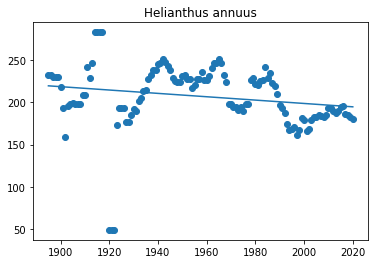

R squared: 0.03858439813280101
MFT: 197.73289183222957
Change in MFT 1895-2020: [-24.85046861]
Change in MFT 1920-2020: [-19.88037489]
Guttata sensu lato 1470


100%|██████████| 126/126 [00:00<00:00, 809.82it/s]


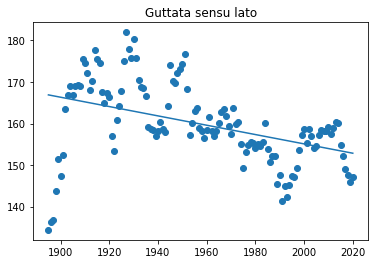

R squared: 0.1799591214645726
MFT: 158.11802721088435
Change in MFT 1895-2020: [-14.04753884]
Change in MFT 1920-2020: [-11.23803107]


In [10]:
window = 4

for sp, subset in subsets.items():
    subset = subset[["year", "startDayOfYear", "flowering"]].dropna()
    avg_month_flower = []
    high_CI = []
    low_CI = []
    avg_month_years = []
    years = []
    if len(subset) < 100:
        continue
    else:
        print(sp, len(subset), flush=True)
    for center_yr in tqdm(range(subset["year"].min(), subset["year"].max()+1)):
        considered = subset.loc[(abs(subset["year"] - center_yr) <= window)].drop("year", axis=1)
        flowering_days = considered.loc[considered["flowering"]==1, "startDayOfYear"]
        if len(flowering_days) < 1:
            continue
        mean_flowering_day = flowering_days.mean()
        avg_month_flower.append(mean_flowering_day)
        high_CI.append(mean_flowering_day + flowering_days.std()/np.sqrt(len(flowering_days)))
        low_CI.append(mean_flowering_day - flowering_days.std()/np.sqrt(len(flowering_days)))
        avg_month_years.append(center_yr)
    avg_month_flower = np.array(avg_month_flower)
    avg_month_years = np.array(avg_month_years)
    years = np.array(years)
    lr = LinearRegression()
    lr.fit(avg_month_years.reshape(-1,1), avg_month_flower)
    R_squared = lr.score(avg_month_years.reshape(-1,1), avg_month_flower)
    preds = lr.predict(avg_month_years.reshape(-1,1))
    plt.scatter(avg_month_years.reshape(-1,1), avg_month_flower)
    plt.plot(avg_month_years, preds, label="Regression")
    plt.title(sp)
    plt.show()
    print("R squared:", R_squared)
    print("MFT:", subset["startDayOfYear"].mean())
    print("Change in MFT 1895-2020:", lr.predict([[2020]]) - lr.predict([[1895]]))
    print("Change in MFT 1920-2020:", lr.predict([[2020]]) - lr.predict([[1920]]))

Cuscuta campestris 116


100%|██████████| 123/123 [00:00<00:00, 726.46it/s]

Trifolium pratense 155



100%|██████████| 124/124 [00:00<00:00, 736.85it/s]

Ricinus communis 264



100%|██████████| 117/117 [00:00<00:00, 726.89it/s]

Brassica rapa 367



100%|██████████| 125/125 [00:00<00:00, 731.32it/s]

Raphanus sativus 573



100%|██████████| 126/126 [00:00<00:00, 751.85it/s]

Nicotiana attenuata 380



100%|██████████| 123/123 [00:00<00:00, 731.31it/s]

Helianthus annuus 453



100%|██████████| 126/126 [00:00<00:00, 723.08it/s]

Guttata sensu lato 1470



100%|██████████| 126/126 [00:00<00:00, 737.21it/s]


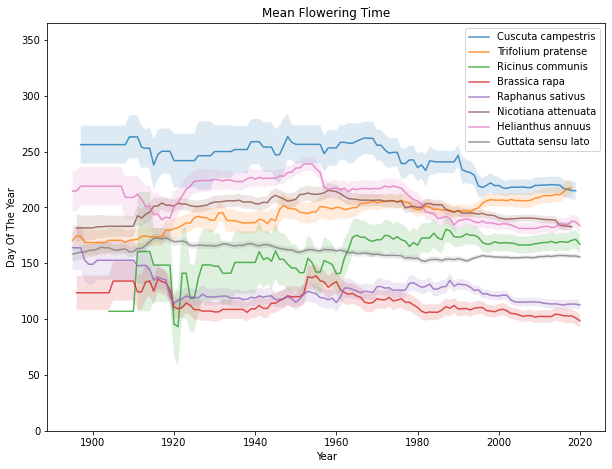

In [11]:
window = 16

for sp, subset in subsets.items():
    subset = subset[["year", "startDayOfYear", "flowering"]].dropna()
    avg_month_flower = []
    high_CI = []
    low_CI = []
    avg_month_years = []
    years = []
    if len(subset) < 100:
        continue
    else:
        print(sp, len(subset), flush=True)
    for center_yr in tqdm(range(subset["year"].min(), subset["year"].max()+1)):
        considered = subset.loc[(abs(subset["year"] - center_yr) <= window)].drop("year", axis=1)
        flowering_days = considered.loc[considered["flowering"]==1, "startDayOfYear"]
        avg_month_flower.append(flowering_days.mean())
        high_CI.append(flowering_days.mean() + flowering_days.std()/np.sqrt(len(flowering_days)))
        low_CI.append(flowering_days.mean() - flowering_days.std()/np.sqrt(len(flowering_days)))
        avg_month_years.append(center_yr)
    avg_month_flower = np.array(avg_month_flower)
    avg_month_years = np.array(avg_month_years)
    years = np.array(years)
    plt.fill_between(avg_month_years, low_CI, high_CI, alpha=0.15)
    plt.plot(avg_month_years, avg_month_flower, alpha=0.8, label=sp)
plt.xlabel("Year")
plt.ylabel("Day Of The Year")
plt.legend()
plt.ylim((0, 365))
plt.gcf().set_size_inches(10, 7.5)
plt.title("Mean Flowering Time")
plt.show()

100%|██████████| 126/126 [00:00<00:00, 746.11it/s]


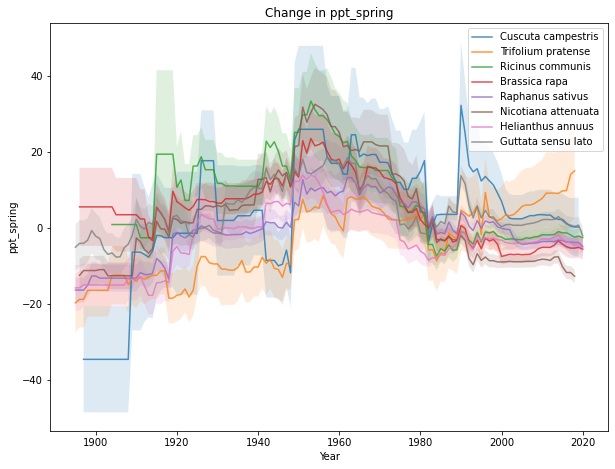

In [12]:
window = 16
climate_var = "ppt_spring"
for sp, subset in subsets.items():
    subset = subset[["year", "startDayOfYear", "flowering", climate_var]].dropna()
    avg_month_flower = []
    high_CI = []
    low_CI = []
    avg_month_years = []
    years = []
    for center_yr in tqdm(range(subset["year"].min(), subset["year"].max()+1)):
        considered = subset.loc[(abs(subset["year"] - center_yr) <= window)].drop("year", axis=1)
        flowering_days = considered.loc[considered["flowering"]==1, climate_var]
        avg_month_flower.append(flowering_days.mean())
        high_CI.append(flowering_days.mean() + flowering_days.std()/np.sqrt(len(flowering_days)))
        low_CI.append(flowering_days.mean() - flowering_days.std()/np.sqrt(len(flowering_days)))
        avg_month_years.append(center_yr)
    avg_month_flower = np.array(avg_month_flower)
    avg_month_years = np.array(avg_month_years)
    years = np.array(years)
    plt.fill_between(avg_month_years, low_CI, high_CI, alpha=0.15)
    plt.plot(avg_month_years, avg_month_flower, alpha=0.8, label=sp)
plt.xlabel("Year")
plt.ylabel(climate_var)
plt.legend()
plt.gcf().set_size_inches(10, 7.5)
plt.title("Change in {}".format(climate_var))
plt.show()

In [13]:
climate_var_bases = ["tmax_", "tmin_", "tmean_"]
climate_vars = [c for c in cch2.columns if any([c.startswith(v) for v in climate_var_bases])]
print(len(climate_vars))
climate_vars = [c for c in climate_vars if "at_collection" not in c]
print(len(climate_vars))

15
12


In [14]:
R_squared_df = []
p_val_df = []
score_df = []
species_counts = [[], []]

for sp, subset in subsets.items():
    subset = subset.loc[(subset["flowering"]==1), ["year", "startDayOfYear"]+climate_vars].dropna()
    species_counts[0].append(sp)
    species_counts[1].append(len(subset))
    R2_row = {}
    pval_row = {}
    score_row = {}
    for climate_var in climate_vars:
        # print("#####  {}  #####".format(sp))
        r_2, p_vals, slope = run_linear_model(subset[[climate_var]],
                                              subset["startDayOfYear"],
                                              verbose=False, skip_insignificant=True, alpha=0.1, plot_flag=False)
        score_row[climate_var] = slope * subset[climate_var].std()
        R2_row[climate_var] = r_2
        pval_row[climate_var] = p_vals[1]
    R_squared_df.append(pd.Series(R2_row, name=sp))
    p_val_df.append(pd.Series(pval_row, name=sp))
    score_df.append(pd.Series(score_row, name=sp))

R_squared_df = pd.DataFrame(R_squared_df)
p_val_df = pd.DataFrame(p_val_df)
score_df = pd.DataFrame(score_df)
species_counts = pd.Series(species_counts[1], index=species_counts[0])
species_counts.sort_values()

Cuscuta campestris      110
Trifolium pratense      150
Ricinus communis        174
Nicotiana attenuata     333
Brassica rapa           342
Helianthus annuus       419
Raphanus sativus        533
Guttata sensu lato     1396
dtype: int64

In [15]:
def heatmap(df, title, size=(14,6), cmap_label="Values"):
    fig, (ax1, ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [29, 1], 'wspace':0.02})
    coll = ax1.pcolor(df)

    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=coll.cmap,
                                    norm=coll.norm,
                                    orientation='vertical')
    cb1.set_label(cmap_label)
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0.5, len(df.index), 1))
    ax1.set_yticklabels(df.index)
    ax1.set_xticks(np.arange(0.5, len(df.columns), 1))
    ax1.set_xticklabels(df.columns, rotation=45, ha="right")
    plt.gcf().set_size_inches(size)
    plt.show()

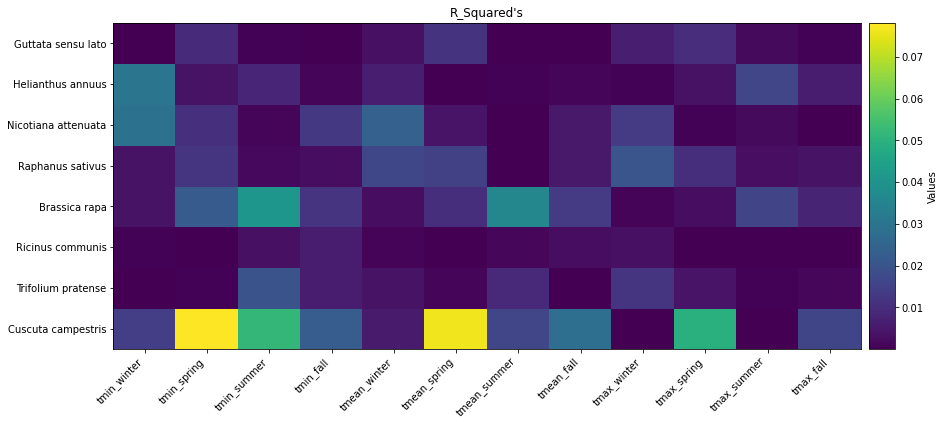

In [16]:
heatmap(R_squared_df, "R_Squared's")

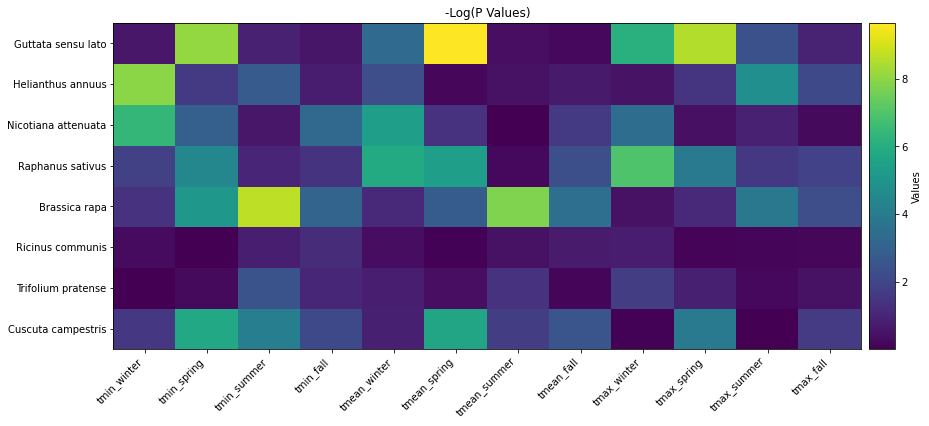

In [17]:
heatmap(np.log(1.0/p_val_df), "-Log(P Values)")

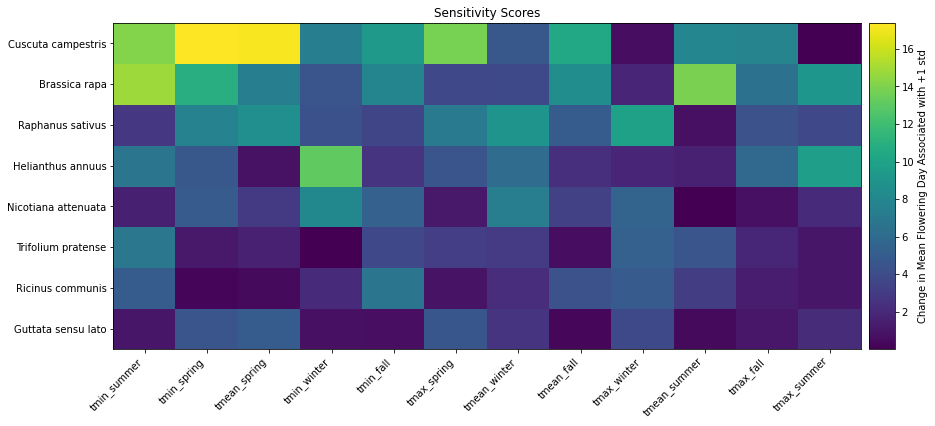

In [18]:
heatmap(abs(score_df).loc[abs(score_df).mean(axis=1).sort_values().index,
                          abs(score_df).mean(axis=0).sort_values(ascending=False).index],
        "Sensitivity Scores", cmap_label="Change in Mean Flowering Day Associated with +1 std")

Text(0.5, 0, 'Change in Mean Flowering Day Associated with +1 std of any climate variable')

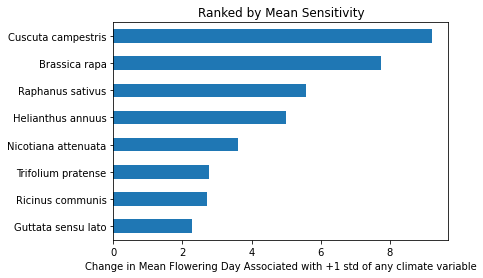

In [19]:
# Ranking of Sensitivity based on average sensitivity over all climate variables
abs(score_df).mean(axis=1).sort_values().plot.barh(title="Ranked by Mean Sensitivity")
plt.xlabel("Change in Mean Flowering Day Associated with +1 std of any climate variable")

Text(0.5, 0, 'Change in Mean Flowering Day Associated with +1 std of the most impactful climate variable')

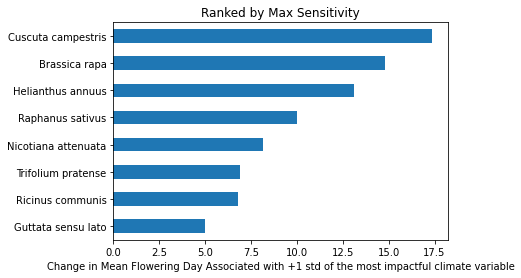

In [20]:
# Ranking of Sensitivity based on highest sensitivity over all climate variables
abs(score_df).max(axis=1).sort_values().plot.barh(title="Ranked by Max Sensitivity")
plt.xlabel("Change in Mean Flowering Day Associated with +1 std of the most impactful climate variable")

In [21]:
# Is this just indicative of having few samples, though?
species_counts.sort_values(ascending=False)

Guttata sensu lato     1396
Raphanus sativus        533
Helianthus annuus       419
Brassica rapa           342
Nicotiana attenuata     333
Ricinus communis        174
Trifolium pratense      150
Cuscuta campestris      110
dtype: int64

<AxesSubplot:title={'center':'Sensitivity vs Sample Size'}, xlabel='log(count)', ylabel='sensitivity'>

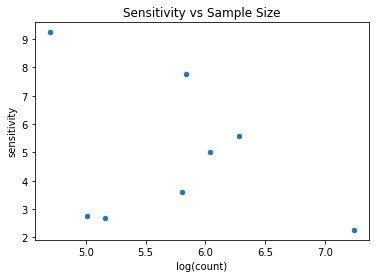

In [22]:
pd.DataFrame({"sensitivity":abs(score_df).mean(axis=1), "log(count)":np.log(species_counts)}).plot.scatter("log(count)", "sensitivity", title="Sensitivity vs Sample Size")

##############################
Linear model:
Predicting log(count) from ['sensitivity']


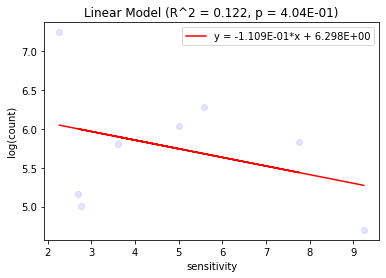

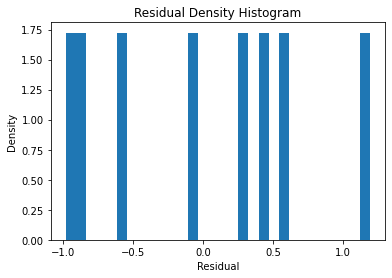

##############################



(0.12177708408668164,
 [0.00021162041455413672, 0.4035354147038126],
 -0.11092433178582385)

In [23]:
temp_df = pd.DataFrame({"sensitivity":abs(score_df).mean(axis=1), "log(count)":np.log(species_counts)})
run_linear_model(temp_df[["sensitivity"]], temp_df["log(count)"], verbose=True)

In [27]:
# Which variable is each species most sensitive to?
abs(score_df).T.idxmax()

Cuscuta campestris      tmin_spring
Trifolium pratense      tmin_summer
Ricinus communis          tmin_fall
Brassica rapa           tmin_summer
Raphanus sativus        tmax_winter
Nicotiana attenuata     tmin_winter
Helianthus annuus       tmin_winter
Guttata sensu lato     tmean_spring
dtype: object

In [28]:
p_val_df.describe().loc["min"]

tmin_winter     0.000344
tmin_spring     0.000309
tmin_summer     0.000166
tmin_fall       0.040437
tmean_winter    0.002851
tmean_spring    0.000064
tmean_summer    0.000413
tmean_fall      0.032155
tmax_winter     0.000969
tmax_spring     0.000192
tmax_summer     0.008581
tmax_fall       0.101475
Name: min, dtype: float64

In [29]:
p_val_df.T.idxmin()

Cuscuta campestris      tmin_spring
Trifolium pratense      tmin_summer
Ricinus communis          tmin_fall
Brassica rapa           tmin_summer
Raphanus sativus        tmax_winter
Nicotiana attenuata     tmin_winter
Helianthus annuus       tmin_winter
Guttata sensu lato     tmean_spring
dtype: object

In [30]:
R_squared_df.T.idxmax()

Cuscuta campestris      tmin_spring
Trifolium pratense      tmin_summer
Ricinus communis          tmin_fall
Brassica rapa           tmin_summer
Raphanus sativus        tmax_winter
Nicotiana attenuata     tmin_winter
Helianthus annuus       tmin_winter
Guttata sensu lato     tmean_spring
dtype: object